# Climate Data Generator: Temperature edition

This notebook is intended to help beginner (me included) to generate daily data from monthly mean data.

The objective of this notebook is as follows:
1. Changing day of year to t' as our predictor
2. build regression based on fourier series, with var from step 1 as predictor
3. predict (generate) daily temperature
4. viz and evaluate the generated data

Predictand of this study will be the monthly mean temperature, while for evalutation we will compare the generated data with its daily observed value from K Station.


The csv data input used in this study consists of columns as follows:
adjust your data input accordingly

In [57]:
import os
import numpy as np
import pandas as pd
import time
import glob
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sb

from scipy.optimize import Bounds

In [2]:
pwd = os.getcwd()
dir_input = os.path.join(pwd, 'Input')
dir_out = os.path.join(pwd, 'Output')
MAGIC = 69

In [43]:
file_csv = glob.glob(os.path.join(dir_input, '*temperature*.csv'))[0]
df_ = pd.read_csv(file_csv)
var_ = df_.columns[-1]
df_[var_] = pd.to_numeric(df_[var_], errors='coerce')
df_.head(4)

,Tahun,Bulan,Tanggal,Temperature
0,1986,1,1,26.8
1,1986,1,2,27.1
2,1986,1,3,26.7
3,1986,1,4,26.8


In [44]:
df_['Date_'] = pd.to_datetime(df_[['Tahun', 'Bulan', 'Tanggal']].astype(
    str).apply('-'.join, axis=1))
df_['Date_'] = pd.to_datetime(df_['Date_']).dt.date
df_['Date_'] = pd.to_datetime(df_['Date_'])
df_['Hari_ke'] = df_['Date_'].dt.dayofyear

# buat df baru untuk menampung semua jumlah hari dan tahun dari df_
n_hari = df_.groupby(['Bulan', 'Tahun']).size()
n_hari.shape

(420,)

In [45]:
# merge n_hari ke df_

df_ = df_.merge(n_hari.rename('n_hari'), on=['Bulan', 'Tahun'])
# df_ = df_.drop(columns=['n_hari_drop'])

# cek klo memang bener langkah kita hehehe
df_.loc[df_.Bulan==2]

,Tahun,Bulan,Tanggal,Temperature,Date_,Hari_ke,n_hari
31,1986,2,1,25.4,1986-02-01,32,28
32,1986,2,2,26.6,1986-02-02,33,28
33,1986,2,3,25.9,1986-02-03,34,28
34,1986,2,4,26.8,1986-02-04,35,28
35,1986,2,5,27.2,1986-02-05,36,28
...,...,...,...,...,...,...,...
12473,2020,2,25,28.3,2020-02-25,56,29
12474,2020,2,26,28.1,2020-02-26,57,29
12475,2020,2,27,26.5,2020-02-27,58,29
12476,2020,2,28,28.3,2020-02-28,59,29


### We must also add monthly mean of temperature, then add it to our df_

lessgo

In [51]:
# hitung dulu nilai monthly mean. buruan ambil kalkulator ya bro
mean_suhu = df_.groupby(df_['Date_'].dt.to_period('M')).agg({'Temperature': 'mean'}).reset_index()
mean_suhu = mean_suhu.rename(columns={'Temperature': 'T_mo_avg'})

mean_suhu['Tahun'] = mean_suhu.Date_.dt.year
mean_suhu['Bulan'] = mean_suhu.Date_.dt.month
mean_suhu

,Date_,T_mo_avg,Tahun,Bulan
0,1986-01,26.816129,1986,1
1,1986-02,26.314286,1986,2
2,1986-03,26.258065,1986,3
3,1986-04,26.550000,1986,4
4,1986-05,25.938710,1986,5
...,...,...,...,...
415,2020-08,25.461290,2020,8
416,2020-09,26.000000,2020,9
417,2020-10,26.922581,2020,10
418,2020-11,27.576667,2020,11


In [52]:
# gabungin mean_suhu ke df_
df_ = df_.merge(mean_suhu[['Tahun', 'Bulan', 'T_mo_avg']],
                on=['Tahun', 'Bulan'], how='left')
df_.loc[df_.Tahun==2020]

,Tahun,Bulan,Tanggal,Temperature,Date_,Hari_ke,n_hari,T_mo_avg
12418,2020,1,1,28.5,2020-01-01,1,31,28.216129
12419,2020,1,2,27.2,2020-01-02,2,31,28.216129
12420,2020,1,3,27.1,2020-01-03,3,31,28.216129
12421,2020,1,4,27.6,2020-01-04,4,31,28.216129
12422,2020,1,5,28.4,2020-01-05,5,31,28.216129
...,...,...,...,...,...,...,...,...
12779,2020,12,27,26.8,2020-12-27,362,31,27.832258
12780,2020,12,28,27.1,2020-12-28,363,31,27.832258
12781,2020,12,29,27.6,2020-12-29,364,31,27.832258
12782,2020,12,30,28.4,2020-12-30,365,31,27.832258


Our preparation is almost complete. now we will determine the value of t and t_star, which the latter will later serve as our predictor.
Based on the slide provided by Mr. B, the formula we use here is:

t = ((Bulan - 0.5) + (Tanggal - 0.5)) / n_hari  

t_star = 2 * pi * t / 12

now, lessgo!

In [78]:
df_['t'] = ((df_.Bulan-0.5) + (df_.Hari_ke - 0.5)) / df_.n_hari
df_['t_star'] = 2 * np.pi * df_['t'] / 12
df_

,Tahun,Bulan,Tanggal,Temperature,Date_,Hari_ke,n_hari,T_mo_avg,t,t_star,Temp_gen
0,1986,1,1,26.8,1986-01-01,1,31,26.816129,0.032258,0.016890,27.546210
1,1986,1,2,27.1,1986-01-02,2,31,26.816129,0.064516,0.033781,27.248697
2,1986,1,3,26.7,1986-01-03,3,31,26.816129,0.096774,0.050671,27.002161
3,1986,1,4,26.8,1986-01-04,4,31,26.816129,0.129032,0.067561,26.801299
4,1986,1,5,27.4,1986-01-05,5,31,26.816129,0.161290,0.084451,26.641029
...,...,...,...,...,...,...,...,...,...,...,...
12779,2020,12,27,26.8,2020-12-27,362,31,27.832258,12.032258,6.300076,26.405588
12780,2020,12,28,27.1,2020-12-28,363,31,27.832258,12.064516,6.316966,26.522480
12781,2020,12,29,27.6,2020-12-29,364,31,27.832258,12.096774,6.333856,26.674994
12782,2020,12,30,28.4,2020-12-30,365,31,27.832258,12.129032,6.350746,26.867972


With this,

## Step 1 is completed!!!!

feat: df_ with col t, t_star, and T_mo_avg in it. crucial step as these vars will serve as preds in the next step

## 2. Fourier-series regression

in this step, we will build regression based on fourier series that will later serve as our model to generate daily rainfall.

tbh, the instruction in this phase is vague. i use only a slide and basic understanding of SS from my lecturer to make and build the reg function.
should you read this and follow this instructions without having any grasp of what you're doing, welp, suit yourself

just like previous study (or notebook, if you find this shitty notebook on my github, somehow lol), we will employ curve_fit function from scipy, just to make our life easier trolol

off we go!

In [79]:
# yea beach we use fourier with 2 harmonics
fourier_koef = pd.DataFrame(columns=('a0', 'a1', 'b1', 'a2', 'b2'))

def reg_fourier(t, a0, a1, b1, a2, b2):
    return a0 + a1 * np.cos(t) + b1 * np.sin(t) + a2 * np.cos(2 * t) + b2 * np.sin(2 * t)

batas_bawah = [-np.inf, -np.inf, -np.inf, -np.inf, -np.inf]
batas_atas = [np.inf, np.inf, np.inf, np.inf, np.inf]

dfinput = df_[['t_star', 'T_mo_avg']].copy()
dfinput = dfinput.dropna()
popt, pcov = curve_fit(
    reg_fourier, dfinput['t_star'], dfinput['T_mo_avg'], bounds=(batas_bawah, batas_atas))
fourier_koef.loc[0] = popt

fourier_koef

,a0,a1,b1,a2,b2
0,26.338858,0.869615,0.578513,0.007856,-0.389612


With this,
## step 2 is done! voila

for the next step, we will calculate the daily data using the fourier coef we obtained in fourier_koef.

the predicted (or generated) value of daily data is then attached to df_, assigned as 'Temp_gen'

## 3. generate daily data with fourier series reg

it is pretty straighforward. or perhaps youve been sleeping this whole time?

In [80]:
# remember this function?

def hitung_FR(t, lis_):
    """
    use this function to call the obtained fourier reg coef
    and calculate the prob logit
    be sure to use tprime as input t here
    """
    a0, a1, b1, a2, b2 = lis_
    hasil_ = a0 + a1 * np.cos(t) + b1 * np.sin(t) \
        + a2 * np.cos(2 * t) + b2 * np.sin(2 * t)
    return hasil_

lis_ = fourier_koef.loc[0]
hasil_ = hitung_FR(df_['t_star'], lis_)
df_['Temp_gen'] = hasil_

df_

,Tahun,Bulan,Tanggal,Temperature,Date_,Hari_ke,n_hari,T_mo_avg,t,t_star,Temp_gen
0,1986,1,1,26.8,1986-01-01,1,31,26.816129,0.032258,0.016890,27.212812
1,1986,1,2,27.1,1986-01-02,2,31,26.816129,0.064516,0.033781,27.209050
2,1986,1,3,26.7,1986-01-03,3,31,26.816129,0.096774,0.050671,27.205057
3,1986,1,4,26.8,1986-01-04,4,31,26.816129,0.129032,0.067561,27.200843
4,1986,1,5,27.4,1986-01-05,5,31,26.816129,0.161290,0.084451,27.196421
...,...,...,...,...,...,...,...,...,...,...,...
12779,2020,12,27,26.8,2020-12-27,362,31,27.832258,12.032258,6.300076,27.212812
12780,2020,12,28,27.1,2020-12-28,363,31,27.832258,12.064516,6.316966,27.209050
12781,2020,12,29,27.6,2020-12-29,364,31,27.832258,12.096774,6.333856,27.205057
12782,2020,12,30,28.4,2020-12-30,365,31,27.832258,12.129032,6.350746,27.200843


In [97]:
fourier_koef

,a0,a1,b1,a2,b2
0,26.338858,0.869615,0.578513,0.007856,-0.389612


and with this, as you may have guessed, 
## we've done step 3!!!!

yahoooo. yea it surely feels too easy. omitting markov chain surely makes everything a lot easier imo

final step is also a bit hard, as we will tinker with plotting and all.
the problem is to make the plot meaningful, and also pretty at the same time

and im not really keen and excited to make anything related with plots and arts (in some way).

well, ikuzo!

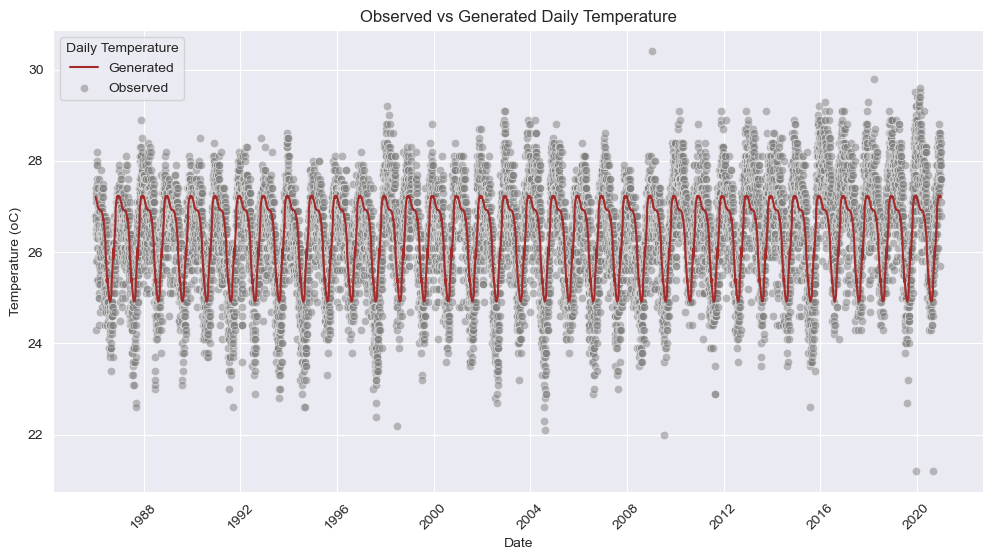

In [81]:
# plot realtime obs vs generated data, daily

sb.set_style("darkgrid")
sb.set_palette("husl")

plt.figure(figsize=(12, 6))
line_obs = sb.lineplot(
    x='Date_', y="Temp_gen", color='brown', 
    data=df_, label="Generated")
scatter = sb.scatterplot(
    data=df_, x='Date_', y='Temperature',
    color='grey', alpha=0.5, label='Observed')
plt.xlabel("Date")
plt.ylabel("Temperature (oC)")
plt.title("Observed vs Generated Daily Temperature")
plt.xticks(rotation=45)
plt.legend(title="Daily Temperature")

namafile = os.path.join(dir_out, 'Suhu_Obs_vs_Generated_Daily.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()


Plot shows that our generated daily rainfall is not necessarily suitable to be used on event-based analysis.
Since its predictor only consists of static data (in our case, date of month), the generated won't fluctuate much around certain value.

To better understand this, let's select certain year and breakdown the plot above. We will basically try to demonstrate how our generated data is static, and can only be seen as normal-daily data. We will later plot the generated vs normal data, to see if the generated data actually follows the normal daily or not.

For the plot below, let's choose 1989, 1992, 1997, 2005, 2010, and 2020

In [63]:
df_

,Tahun,Bulan,Tanggal,Temperature,Date_,Hari_ke,n_hari,T_mo_avg,t,t_star,Temp_gen
0,1986,1,1,26.8,1986-01-01,1,31,26.816129,0.032258,0.016890,27.546210
1,1986,1,2,27.1,1986-01-02,2,31,26.816129,0.064516,0.033781,27.248697
2,1986,1,3,26.7,1986-01-03,3,31,26.816129,0.096774,0.050671,27.002161
3,1986,1,4,26.8,1986-01-04,4,31,26.816129,0.129032,0.067561,26.801299
4,1986,1,5,27.4,1986-01-05,5,31,26.816129,0.161290,0.084451,26.641029
...,...,...,...,...,...,...,...,...,...,...,...
12779,2020,12,27,26.8,2020-12-27,362,31,27.832258,1.225806,0.641831,26.405588
12780,2020,12,28,27.1,2020-12-28,363,31,27.832258,1.258065,0.658721,26.522480
12781,2020,12,29,27.6,2020-12-29,364,31,27.832258,1.290323,0.675611,26.674994
12782,2020,12,30,28.4,2020-12-30,365,31,27.832258,1.322581,0.692502,26.867972


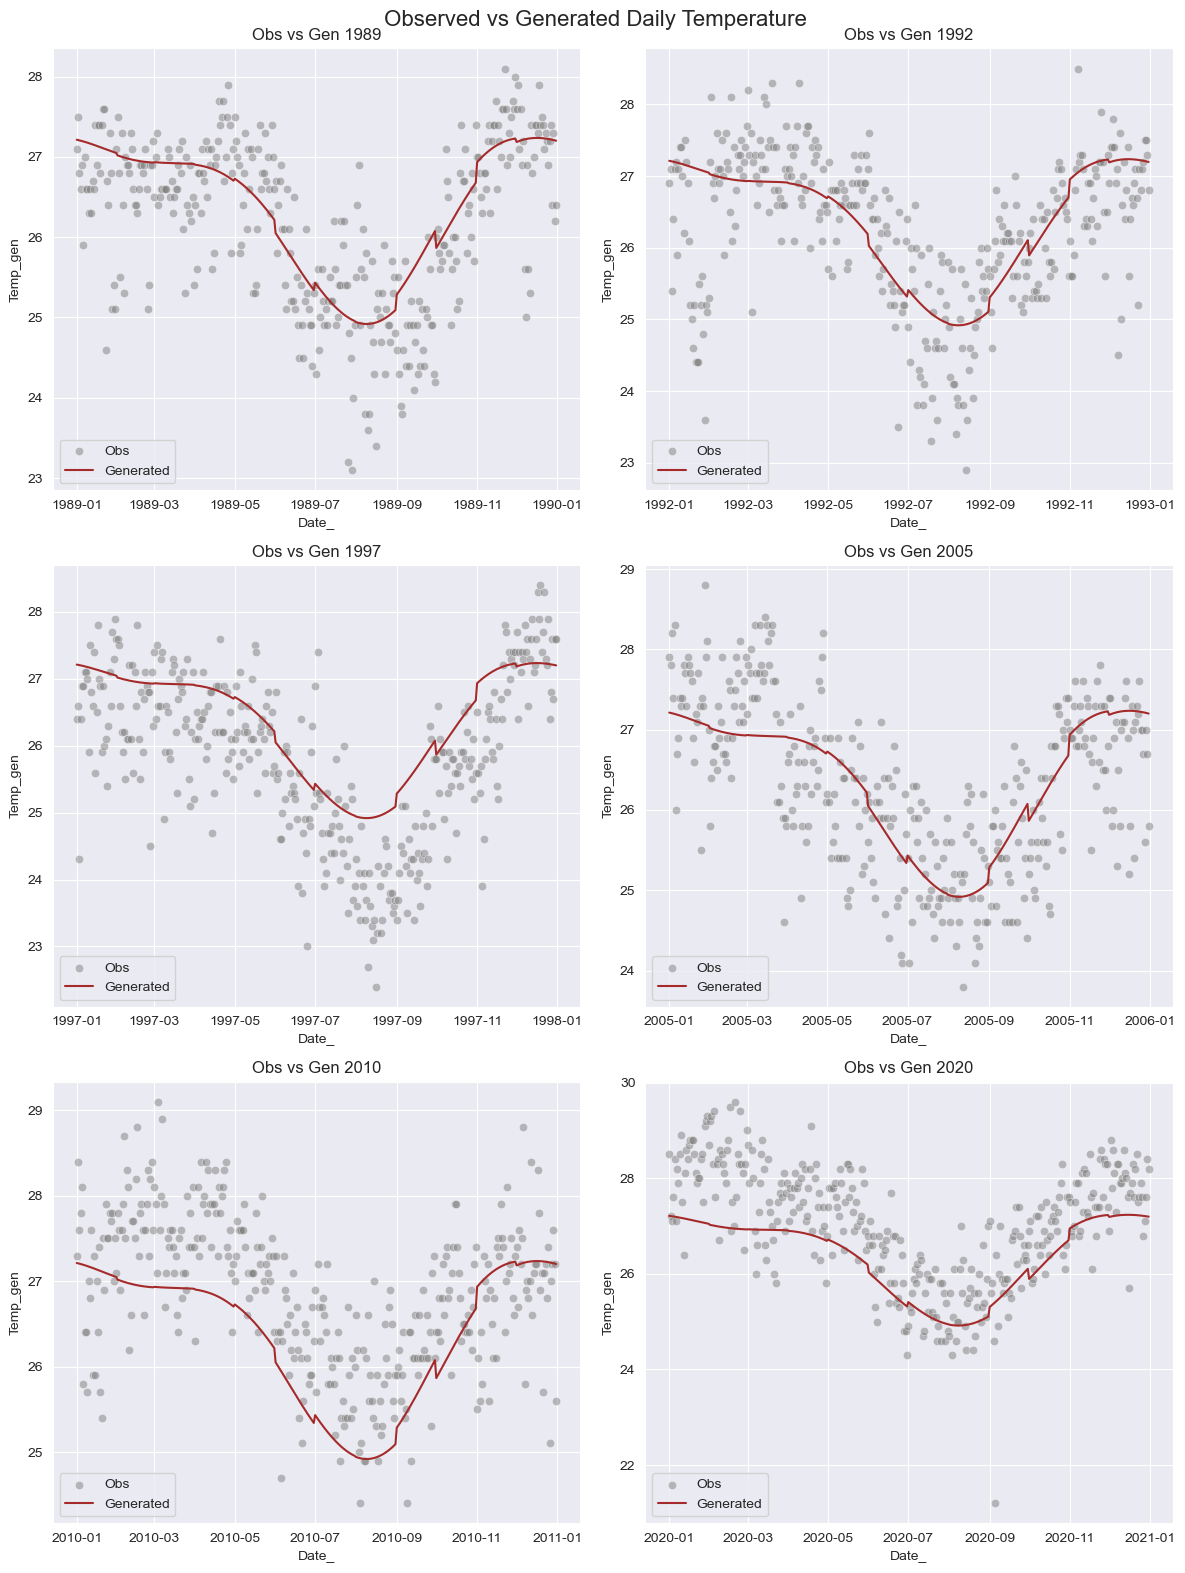

In [82]:
# ngeplot dipisah ben penak

tahun = [1989, 1992, 1997, 2005, 2010, 2020]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

def plot_pertahun(df_plot, tahun_, ax):
    """
    this function will simply help you plot your 
    result, scatter and line
    """
    line_obs = sb.lineplot(
        x='Date_', y="Temp_gen", color='brown', 
        data=df_plot, label="Generated", ax=ax)
    scatter = sb.scatterplot(
        data=df_plot, x='Date_', y='Temperature',
        color='grey', alpha=0.5, label='Observed', ax=ax)
#     ax.xlabel("Date")
#     ax.ylabel("Temperature (oC)")
#     ax.xticks(rotation=45)
    ax.legend(
        handles=[scatter.collections[0], line_obs.lines[0]],
        labels=['Obs', 'Generated'], loc='lower left')
    

for i, tahun_ in enumerate(tahun):
    # mendapatkan letak ax(es) dari plot kita ya njing. sesuaikan 
    # dengan bentuk plotmu ya. disini pake 4x2
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    # calling up necessary dframe, ya tentu result_ dan df_event su
    df_plot = df_.loc[df_.Tahun == tahun_]
    plot_pertahun(df_plot, tahun_, ax)
    ax.set_title('Obs vs Gen {}'.format(tahun_))

judul = 'Observed vs Generated Daily Temperature'
plt.suptitle(judul, fontsize=16)
fig.tight_layout()

namafile = os.path.join(dir_out, 'BreakdownSuhu_Obs_vs_Gen_Daily.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()



Yea this new plot is surely easier to read. now we will plot the daily generated vs normal daily obs

In [94]:
daily_avg = df_.groupby(['Hari_ke'])[['Temperature', 'Temp_gen']]\
    .mean().reset_index()

daily_avg

,Hari_ke,Temperature,Temp_gen
0,1,26.988571,27.212812
1,2,26.980000,27.209050
2,3,26.865714,27.205057
3,4,26.942857,27.200843
4,5,27.317143,27.196421
...,...,...,...
361,362,27.232353,27.212812
362,363,27.035294,27.209050
363,364,27.373529,27.205057
364,365,27.129412,27.200843


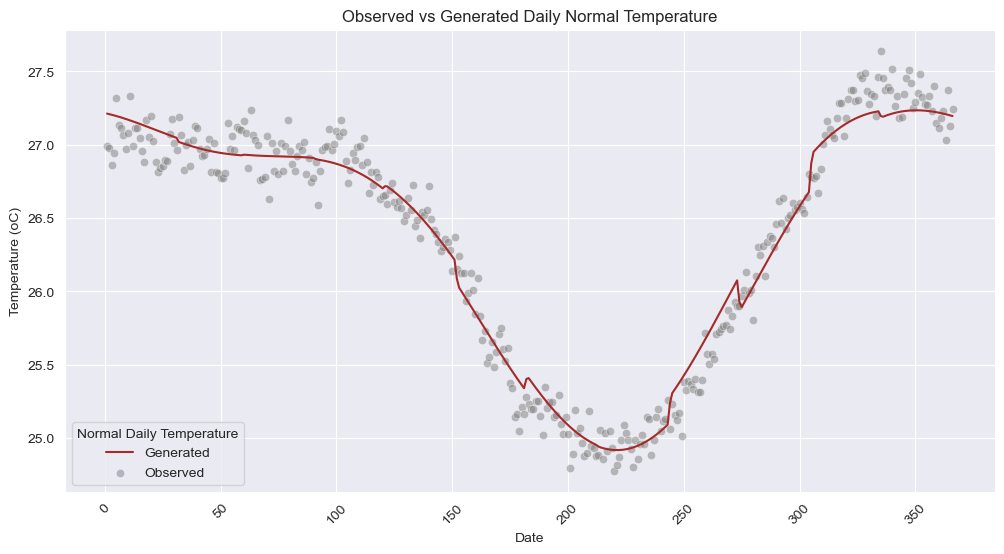

In [96]:
plt.figure(figsize=(12, 6))
line_obs = sb.lineplot(x='Hari_ke', y="Temp_gen", color='brown',
    data=daily_avg, label="Generated")
scatter = sb.scatterplot(
    data=daily_avg, x='Hari_ke', y='Temperature',
    color='grey', alpha=0.5, label='Observed')
plt.xlabel("Date")
plt.ylabel("Temperature (oC)")
plt.title("Observed vs Generated Daily Normal Temperature")
plt.xticks(rotation=45)
plt.legend(title="Normal Daily Temperature")

namafile = os.path.join(dir_out, 'MeanDaily_Suhu_Obs_vs_Gen.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()


Plot CDF and PDF, because they're good lol

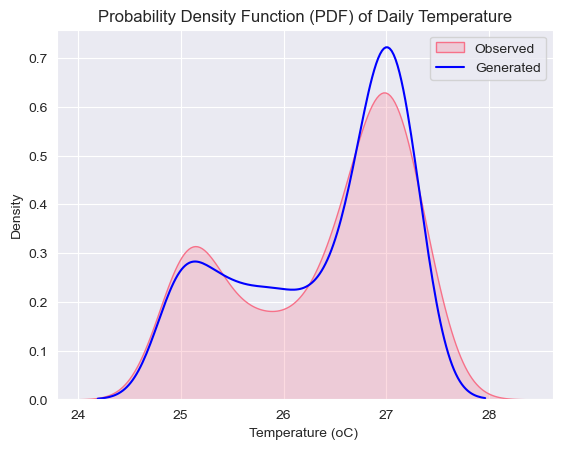

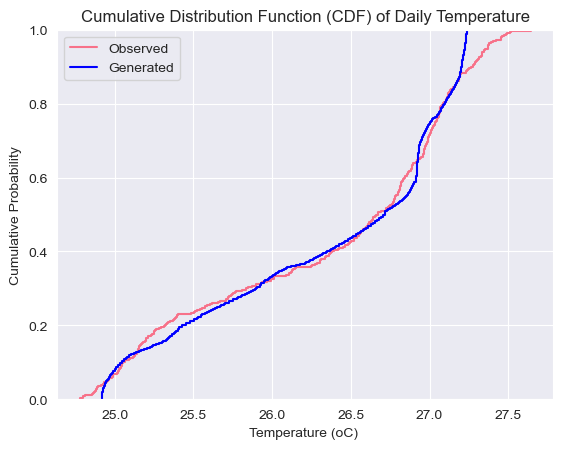

In [99]:
#now let's plot PDF and CDF for daily temperature

sb.kdeplot(data=daily_avg['Temperature'], cumulative=False, fill=True)
sb.kdeplot(data=daily_avg['Temp_gen'],
           cumulative=False, fill=False, color='blue')

plt.xlabel("Temperature (oC) ")
plt.ylabel("Density")
plt.title("Probability Density Function (PDF) of Daily Temperature")

plt.legend(labels=['Observed', 'Generated'])
# plt.xlim(, 150)
namafile = os.path.join(dir_out, 'Temperature_PDF_dailymean.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

# CDF
sb.ecdfplot(data=daily_avg['Temperature'])
sb.ecdfplot(data=daily_avg['Temp_gen'], color='blue')

plt.xlabel("Temperature (oC) ")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function (CDF) of Daily Temperature")

plt.legend(labels=['Observed', 'Generated'])
# plt.xlim(-5, 150)
namafile = os.path.join(dir_out, 'Temperature_CDF_dailymean.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')
plt.show()

Mari melakukan uji wicoxon-mann-whitney

In [100]:
daily_avg

,Hari_ke,Temperature,Temp_gen
0,1,26.988571,27.212812
1,2,26.980000,27.209050
2,3,26.865714,27.205057
3,4,26.942857,27.200843
4,5,27.317143,27.196421
...,...,...,...
361,362,27.232353,27.212812
362,363,27.035294,27.209050
363,364,27.373529,27.205057
364,365,27.129412,27.200843


C:\Users\steve\anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


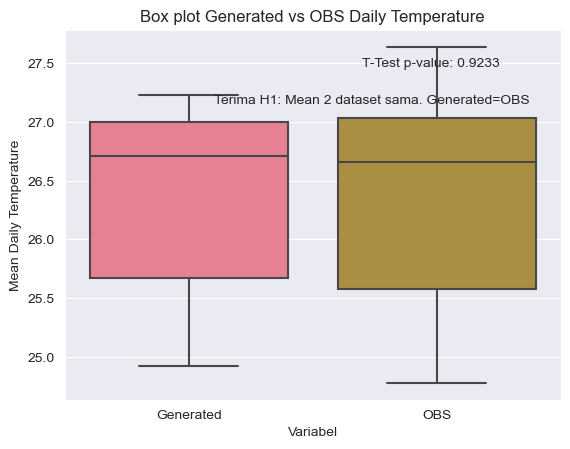

In [103]:
from scipy.stats import ttest_ind

ax = sb.boxplot(data=daily_avg[['Temp_gen', 'Temperature']])
ax.set_xticklabels(['Generated', 'OBS'])

# mw_stat, mw_p_value = mannwhitneyu(
#     daily_avg['Temp_gen'], daily_avg['Temperature'], alternative='two-sided')

t_stat, t_p_value = ttest_ind(daily_avg['Temp_gen'], daily_avg['Temperature'])

if mw_p_value < 0.05:
    pesan='Tolak H0: Mean 2 dataset berbeda. Generated =/= OBS'
else:
    pesan='Terima H1: Mean 2 dataset sama. Generated=OBS'
plt.xlabel('Variabel')
plt.ylabel('Mean Daily Temperature')
plt.title('Box plot Generated vs OBS Daily Temperature')

plt.text(0.6, 0.9, f'T-Test p-value: {mw_p_value:.4f}', transform=plt.gca().transAxes)
plt.text(0.3, 0.8, pesan, transform=plt.gca().transAxes)

namafile = os.path.join(dir_out, 'BoxPlot_T-Test_Suhu.png')
plt.savefig(namafile, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [105]:
from scipy.stats import kstest, norm

D, p_value = kstest(daily_avg['Temp_gen'], daily_avg['Temperature'])

# Nilai kritis untuk alpha=0.05
alpha = 0.05

# Menentukan kesimpulan berdasarkan p-value
if p_value < alpha:
    print("Distribusi tidak mengikuti distribusi normal")
else:
    print("Distribusi mengikuti distribusi normal")

Distribusi tidak mengikuti distribusi normal
